In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
import time
import torch
import warnings
import matplotlib.pyplot as plt
from CoExBO._utils import TensorManager
tm = TensorManager()
warnings.filterwarnings('ignore')

c:\Users\mauri\miniconda3\envs\ExplainableBO\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Baseline: CoExBO

## 1. Problem definition
Let's get started with the toy example of two-dimensional Branin function.<br>
More details can be found [here](https://www.sfu.ca/~ssurjano/branin.html)<br>
- bounds: -2 from 3
- variable type: continuous
- ground truth X: [-1.02543108, -1.02543108]
- ground truth Y: 10.6043
- optimisation: maximisation

In [2]:
def BraninFunction(x):
    x = torch.atleast_2d(x)
    return ((x.sin() + (3*x).cos()/2).square() / ((x/2).square()+0.3)).prod(axis=1)

In [3]:
lower_limit = -2
upper_limit = 3
colour_map = 'summer'
resolution = 200
ground_truth = torch.tensor([-1.02543108, -1.02543108])

We assume we have a prior knowledge about this function.<br>
And we try to guide BO to rectify their recommendatation with help of explanation features.<br>
<br>
As we can see, the global maximum is at around [-1, -1].<br>
We can also observe there are 9 peaks for this function.<br>
We can expect BO can be stuck in one of these local maxima.<br>
<br>
Let's try to shepherd BO go to [-1, -1].

## 2. Define domain
Next, we define the domain of interest.
We set domain as uniform distribution bounded -2 from 3.

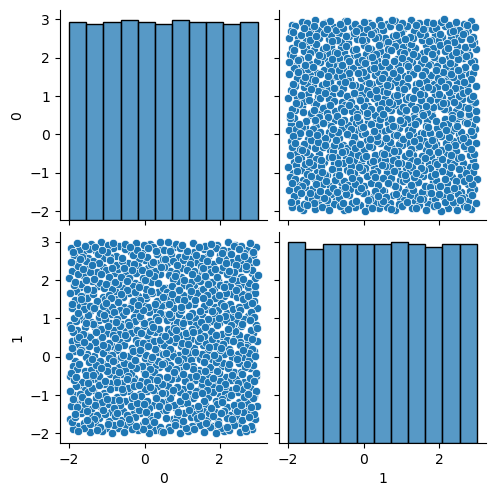

In [4]:
import seaborn as sns
import pandas as pd

# set bounds
n_dims = 2                          # number of dimensions
mins = lower_limit * torch.ones(n_dims)
maxs = upper_limit * torch.ones(n_dims)
bounds = torch.vstack([mins, maxs]) # bounds

# set domain
from CoExBO._prior import Uniform    # Import prior from SOBER libraries
domain = Uniform(bounds)
true_function = BraninFunction

# visualise domain
samples = domain.sample(1000)
sns.pairplot(pd.DataFrame(tm.numpy(samples)))
plt.show()

## 3. Preferential learning
Next, we try to learn the prior knowledge of human user.<br>
For simplicity, human selection process is automatically generated with 60% accuracy via simulation.

In [5]:
from CoExBO._coexbo import CoExBOwithSimulation, StateManager
n_init_pref = 100      # number of initial random samples for preferential learning
n_init_obj = 20        # number of initial random samples for objective function

coexbo = CoExBOwithSimulation(domain, true_function, sigma=0.1)
dataset_obj, dataset_duel = coexbo.initial_sampling(n_init_obj, n_init_pref)

## 4. Run CoExBO
Now, we will collaborate with BO for faster convergence.<br>

In [6]:
n_iterations = 10     # number of iterations
seed = 0              # random seed for reproduce the results

# initial setting
torch.manual_seed(seed)
state = StateManager(n_dims=n_dims)

In [ ]:
results = []
for t in range(n_iterations):
    beta, gamma = state(t)
    result, dataset_obj, dataset_duel = coexbo(
        dataset_obj, dataset_duel, beta, gamma,
    )
    print(f"{len(dataset_obj[0])}) Best value: {dataset_obj[1].max().item():.5e}")
    results.append(result)


results = torch.tensor(results)

0) parameters: beta 5.657e-01 gamma 0.000e+00
22) Best value: 9.94109e+00
Selected point 0: [2.4219999999986612, 9.941092688308839, 0.012588228224260069, 0.5392156862745098]
1) parameters: beta 8.000e-01 gamma 1.000e-02
23) Best value: 1.03934e+01
Selected point 1: [2.07799999999952, 10.393408824470699, 0.0006642313616724234, 0.5339805825242718]
2) parameters: beta 9.798e-01 gamma 4.000e-02
24) Best value: 1.05849e+01
Selected point 2: [2.4840000000003783, 10.584917561037592, 0.0008320231289610708, 0.5384615384615384]
3) parameters: beta 1.131e+00 gamma 9.000e-02


KeyboardInterrupt: 

## Results
[overhead(s), best observation, Euclidean distance between the pairwise candidates, correct_answer_rate]

In [8]:
results

tensor([[3.3280, 5.0299, 8.6427, 0.5990],
        [2.1560, 5.0299, 8.0474, 0.6029],
        [1.9690, 5.0299, 8.5966, 0.6068],
        [1.8910, 5.0366, 8.5408, 0.6010],
        [2.1880, 5.0366, 8.5366, 0.5952],
        [2.1720, 5.0367, 8.5349, 0.5896],
        [2.0150, 5.0367, 8.5423, 0.5841],
        [2.6250, 5.0367, 8.5202, 0.5880],
        [2.5160, 5.0367, 8.5241, 0.5917],
        [2.4220, 5.0367, 8.5498, 0.5955]])